In [1]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.neighbors import KDTree
from sklearn.model_selection import KFold
from sklearn import metrics

In [5]:
name = 'Dataset-ppi--RE-True--W-1--Epochs-5000--D-8--RH-25--LR-0.1--LP-False--CUDA-True'
root = '/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/HBDM/results/models/'+name


### get node and 1d,2d
file_path_d = root+'/latent.pkl'
with open(file_path_d, 'rb') as file:
    node_rep = pickle.load(file)

# tensor = loaded_tensor.cpu()
# node_rep = tensor.detach().numpy()

node_rep = np.array(node_rep)
df_latent = pd.DataFrame()
for d in range(node_rep.shape[1]):
    col_name = str(d+1)+'d'
    df_latent[col_name] = node_rep.T[d]
df_latent['node'] = df_latent.index

df = df_latent
df.head(3)

,1d,2d,3d,4d,5d,6d,7d,8d,node
0,-0.627654,1.059453,-2.601725,2.710630,-0.123076,2.636322,-2.161865,-0.937683,0
1,-0.455810,0.008868,-3.206754,3.420207,1.080242,3.915485,-1.291644,-1.019949,1
2,-0.074531,-0.052813,-0.852389,1.247752,0.531945,1.444922,-0.755664,-0.203969,2


In [8]:
with open('/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/HBDM/data/test/cad_node.pkl', 'rb') as file:
    group_node = pickle.load(file)

# k_values = [10,20,30,40,50]
k_values = [3]
#################################################################################################
# pathways_id = dict(sorted(pathways_id.items(), key=lambda item: item[1], reverse=True)[:10])
outlier = []
#################################################################################################

# for each eomplex, get precision and recall values of varing k
roc_ks = []
pr_ks = []

## get final df: node, cluster, 1d, 2d, label
df['label'] = df['node'].apply(lambda x: 1 if x in group_node else 0)
# Set the index to match the values in column 'node'
df = df.set_index('node')
# Reset the index to its default integer index
df = df.reset_index()

kf = KFold(n_splits=5, shuffle=True, random_state=42)
for k in k_values:
    k+=1
    results = []

    # Build a k-d tree from the points
    kdtree = KDTree(df[[col for col in df.columns if col.endswith('d')]].to_numpy(), leaf_size=20)
    for train_index, test_index in kf.split(group_node):
        train_nodes = [group_node[i] for i in train_index]
        test_nodes = [group_node[i] for i in test_index]
        start = []
        dist = []
        neighbor = []

        for i in train_nodes:
            given_point = df[df['node']==i][[col for col in df.columns if col.endswith('d')]].to_numpy()
            # Perform a k-NN search to find the k+1 nearest neighbors
            distances, indices = kdtree.query(given_point, k=k)
            start += (k-1)*[i]
            dist += distances.reshape(-1).tolist()[1:]
            neighbor += indices.reshape(-1).tolist()[1:]

        neighbor_df = pd.DataFrame({'start': start, 'neighbor': neighbor, 'distance': dist})
        neighbor_df = neighbor_df[~neighbor_df['neighbor'].isin(train_nodes)]
        predict_df = neighbor_df['neighbor'].value_counts().to_frame()
        predict_df.reset_index(inplace=True)
        #predict_df.rename(columns={'neighbor':'count','index':'neighbor'},inplace=True)
        predict_df['true'] = predict_df.apply(lambda row: 1 if row['neighbor'] in test_nodes else 0, axis=1)
        if len(predict_df[predict_df['true']==1])==0:
            results.append([0, 0])
        else:
            predicted_positives = predict_df['count']
            true_positives = predict_df['true']
            precision, recall, thresholds = metrics.precision_recall_curve(true_positives,predicted_positives)
            roc,pr= metrics.roc_auc_score(true_positives,predicted_positives),metrics.auc(recall,precision)
            results.append([roc,pr])
    results = np.array(results)
    roc = np.mean(results[:, 0])
    pr = np.mean(results[:, 1])
    roc_ks.append(roc)
    pr_ks.append(pr)

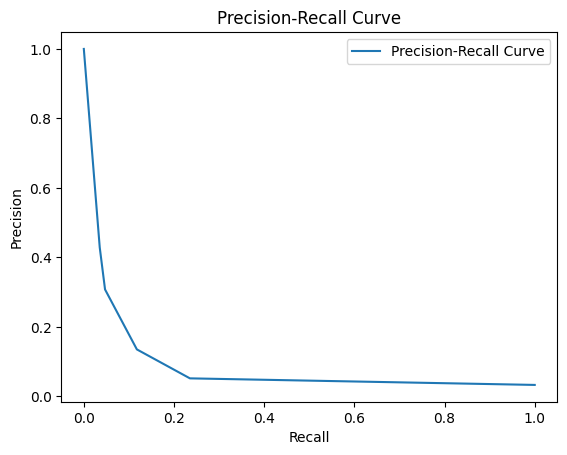

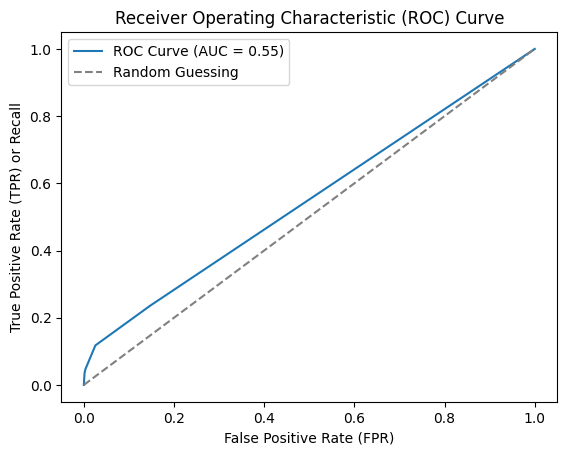

In [9]:
true_labels = true_positives
predicted_scores = predicted_positives
 
# Assuming you have calculated precision, recall, and thresholds using metrics.precision_recall_curve
precision, recall, thresholds = metrics.precision_recall_curve(true_labels, predicted_scores)
 
# Plot the precision-recall curve
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()
 
# Assuming you have calculated fpr (false positive rate), tpr (true positive rate), and thresholds using metrics.roc_curve
fpr, tpr, thresholds = metrics.roc_curve(true_labels, predicted_scores)
 
# Calculate the AUC (Area Under the Curve)
roc_auc = metrics.auc(fpr, tpr)
 
# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guessing')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR) or Recall')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='best')
plt.show()

In [10]:
predict_df.reset_index(inplace=True)


In [11]:
predict_df

,neighbor,count
0,2647,8
1,2629,7
2,2630,6
3,16876,6
4,2906,5
...,...,...
8156,14919,1
8157,11620,1
8158,9428,1
8159,971,1


In [ ]:
predict_df.rename(columns={'neighbor':'count','index':'neighbor'},inplace=True)

In [19]:
with open('/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/HBDM/data/test/complex/human_complexes_node.pkl', 'rb') as file:
    complexs_id = pickle.load(file)
filtered_complex = {key: value for key, value in complexs_id.items() if key not in oulier}

In [21]:
oulier = []

k_values = [2,3,4,5,10,15,20]
precision_complexs= []
recall_complexs=[]

for complex_name in complexs_id:
    group_node = complexs_id[complex_name]
    #if len(group_node) > 4:
    #    continue
    # for each eomplex, get precision and recall values of varing k
    precision_ks = []
    recall_ks = []

    ## get final df: node, cluster, 1d, 2d, label
    df['label'] = df['node'].apply(lambda x: 1 if x in group_node else 0)
    # Set the index to match the values in column 'node'
    df = df.set_index('node')
    # Reset the index to its default integer index
    df = df.reset_index()    
    # with open(output_file, "w") as f:
    for k in k_values:
        k+=1

        kdtree = KDTree(df[[col for col in df.columns if col.endswith('d')]].to_numpy(), leaf_size=20)
        ## the pr list contains all participant results for one knn
        precision = []
        recall = []
        for i in group_node:
            test_nodes = list(set(group_node)-set([i]))
            given_point = df[df['node']==i][[col for col in df.columns if col.endswith('d')]].to_numpy()
            # Perform a k-NN search to find the k+1 nearest neighbors
            distances, indices = kdtree.query(given_point, k=k)
            # start += (k-1)*[i]
            # dist += distances.reshape(-1).tolist()[1:]
            neighbor = indices.reshape(-1).tolist()[1:]

            tp = len(set(neighbor)&set(test_nodes))
            fp = len(neighbor)-tp
            fn = len(test_nodes)-tp

            precision.append(tp/(tp+fp))
            recall.append(tp/(tp+fn))
        precision_ks.append(sum(precision)/len(precision))
        recall_ks.append(sum(recall)/len(recall))
        # if sum(precision) !=0 and sum(recall) !=0:
        #     precision_ks.append(sum(precision)/len(precision))
        #     recall_ks.append(sum(recall)/len(recall))
        # else:
        #     precision_ks.append(0)
        #     recall_ks.append(0)
    if precision_ks.count(0) >= len(k_values)-1:
        oulier.append(complex_name)
    precision_complexs.append(precision_ks)
    recall_complexs.append(recall_ks)

avg_precision = np.array(precision_complexs).mean(axis=0)
avg_recall = np.array(recall_complexs).mean(axis=0)
avg_f1 = 2 * (avg_precision * avg_recall) / (avg_precision + avg_recall)

In [16]:


k_values = [5,10,15,20]
precision_complexs= []
recall_complexs=[]

for complex_name in complexs_id:
    group_node = complexs_id[complex_name]
    if len(group_node) > 4:
        continue
    # for each eomplex, get precision and recall values of varing k
    precision_ks = []
    recall_ks = []

    ## get final df: node, cluster, 1d, 2d, label
    df['label'] = df['node'].apply(lambda x: 1 if x in group_node else 0)
    # Set the index to match the values in column 'node'
    df = df.set_index('node')
    # Reset the index to its default integer index
    df = df.reset_index()    
    # with open(output_file, "w") as f:
    for k in k_values:
        k+=1

        kdtree = KDTree(df[[col for col in df.columns if col.endswith('d')]].to_numpy(), leaf_size=20)
        ## the pr list contains all participant results for one knn
        precision = []
        recall = []
        for i in group_node:
            test_nodes = list(set(group_node)-set([i]))
            given_point = df[df['node']==i][[col for col in df.columns if col.endswith('d')]].to_numpy()
            # Perform a k-NN search to find the k+1 nearest neighbors
            distances, indices = kdtree.query(given_point, k=k)
            # start += (k-1)*[i]
            # dist += distances.reshape(-1).tolist()[1:]
            neighbor = indices.reshape(-1).tolist()[1:]

            tp = len(set(neighbor)&set(test_nodes))
            fp = len(neighbor)-tp
            fn = len(test_nodes)-tp

            precision.append(tp/(tp+fp))
            recall.append(tp/(tp+fn))
        precision_ks.append(sum(precision)/len(precision))
        recall_ks.append(sum(recall)/len(recall))
        # if sum(precision) !=0 and sum(recall) !=0:
        #     precision_ks.append(sum(precision)/len(precision))
        #     recall_ks.append(sum(recall)/len(recall))
        # else:
        #     precision_ks.append(0)
        #     recall_ks.append(0)
    if precision_ks.count(0) >= 3:
        oulier.append(complex_name)
    precision_complexs.append(precision_ks)
    recall_complexs.append(recall_ks)

avg_precision = np.array(precision_complexs).mean(axis=0)
avg_recall = np.array(recall_complexs).mean(axis=0)
avg_f1 = 2 * (avg_precision * avg_recall) / (avg_precision + avg_recall)

In [17]:
avg_f1

array([0.04208838, 0.03576064, 0.03101752, 0.02801012])

In [22]:
avg_f1

array([0.06416688, 0.06659727, 0.06988355, 0.06819395, 0.05645114,
       0.04842233, 0.04375743])

In [7]:
[2,3,4,5,6,7,8,9,10]
len(oulier)

1724

In [11]:
#[5,10,15,20]
len(oulier)

1433

In [13]:
#[5,10,15,20] <4
len(oulier)

1383

In [8]:
len(complexs_id.keys())

2350

In [13]:
import networkx as nx

In [14]:
# Create a random network with 100 nodes
# Parameters
num_nodes = 19000
avg_degree = 78

# Calculate the probability of edge creation
probability = avg_degree / (num_nodes - 1)

# Create the random graph using the Erdős-Rényi model
random_graph = nx.erdos_renyi_graph(num_nodes, probability)

# Create a scale-free network with 19,000 nodes
scale_free_network = nx.scale_free_graph(n=num_nodes)

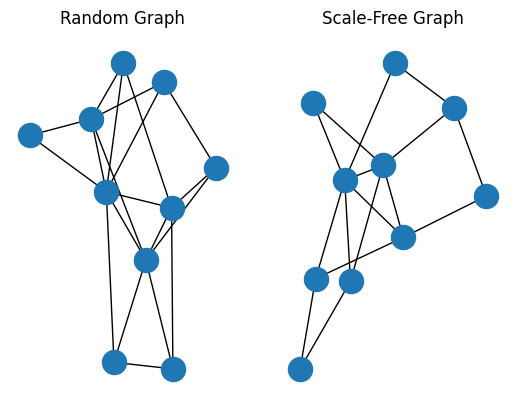

In [18]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a random graph
random_graph = nx.gnm_random_graph(10, 20)

# Create a scale-free graph
scale_free_graph = nx.barabasi_albert_graph(10, 2)

# Plot the random graph
plt.subplot(121)
nx.draw(random_graph, with_labels=False)
plt.title("Random Graph")

# Plot the scale-free graph
plt.subplot(122)
nx.draw(scale_free_graph, with_labels=False)
plt.title("Scale-Free Graph")

# Display the plot
plt.show()

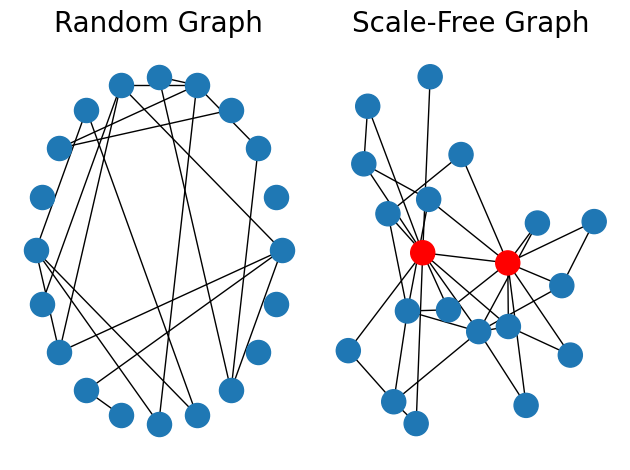

In [35]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a random graph
random_graph = nx.gnm_random_graph(20, 20)

# Create a scale-free graph
scale_free_graph = nx.barabasi_albert_graph(20, 2)

degree_dict = dict(scale_free_graph.degree(scale_free_graph.nodes()))
hub_nodes = [node for node in degree_dict if degree_dict[node] >= 8]

# Create a list of node colors for the graph
node_colors = ['#1F77B4' if node not in hub_nodes else 'red' for node in scale_free_graph.nodes()]



# Plot the random graph
plt.subplot(121)
nx.draw(random_graph,  node_size=300, font_size=16, pos=nx.circular_layout(random_graph))
plt.title("Random Graph", fontsize=20)

# Plot the scale-free graph
plt.subplot(122)
nx.draw(scale_free_graph, node_color=node_colors, node_size=300, font_size=16, pos=nx.spring_layout(scale_free_graph))
plt.title("Scale-Free Graph", fontsize=20)

# Display the plot
plt.tight_layout()
plt.show()

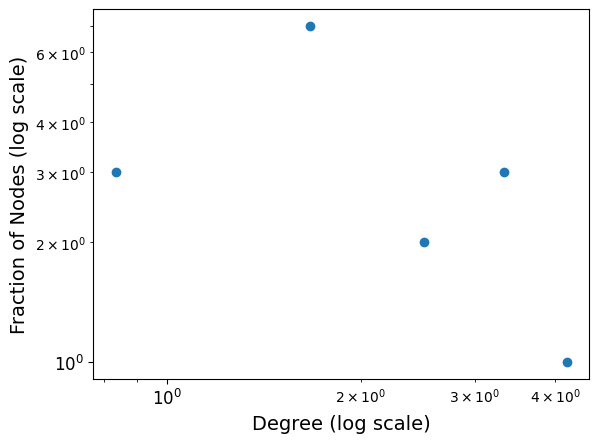

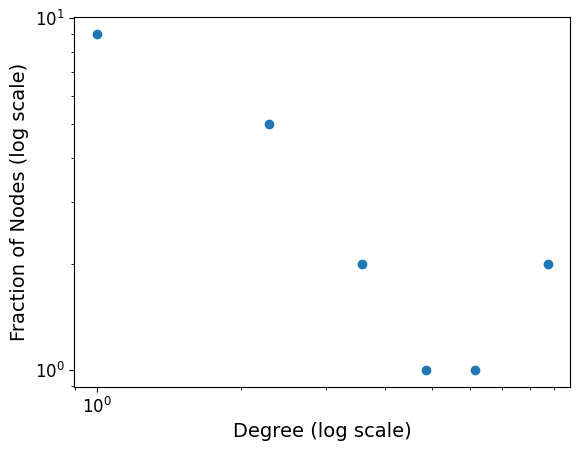

In [37]:
def plot_degree_distribution(name, G, use_weight=False):
    """
    Plot the degree distribution of a graph.

    Parameters:
    - G: NetworkX graph
    - use_weight: Boolean, whether to consider edge weights in the degree calculation
    """

    # Compute the degree distribution
    if use_weight:
        print('weight')
        degree_sequence = sorted([int(d) for n, d in G.degree(weight="combined_score")], reverse=True)
    else:
        degree_sequence = sorted([d for n, d in G.degree()], reverse=True)

    hist, bins = np.histogram(degree_sequence, bins='auto')

    # Plot the degree distribution on a log-log scale
    plt.loglog(bins[:-1], hist, 'o')
    # plt.title(name+" Degree Distribution")
    plt.xticks(fontsize=12)  # Set the fontsize for x-axis tick labels
    plt.yticks(fontsize=12)
    plt.xlabel("Degree (log scale)", fontsize=14)
    plt.ylabel("Fraction of Nodes (log scale)", fontsize=14)
    plt.show()

plot_degree_distribution('random',random_graph, use_weight=False)
plot_degree_distribution('scale free', scale_free_graph, use_weight=False)